# Load Python libraries

In [1]:
# import whatever libraries I want
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import msm_scripts as ms
import test_system_generator as tsg
import timeit

# Generate data

In [46]:
""" So what I'm doing here is generating 20 reaction coordinates and performing 50 simulations for each of coordinates.
I am currently generating 19 single well potentials (initial state chosen randomly) and 1 double well potential (initial
state at transition state)"""

simulation_data = [ ]
num_of_sims_pc = 1
num_of_coors = 10

well = ['single_well']*(num_of_coors-1)
well.append('double_well')
well = well*num_of_sims_pc

init = [0]*(num_of_coors-1)
init.append(50)
init = init*num_of_sims_pc

for i in range(len(well)):
    # define a simulation object in a given potential with a particular biasing force
    sim=tsg.simulation(potential=well[i],sim_length=50000,dt=1,biasing_protocol=[0,1],num_of_states=100,T=300, initial_state = init[i])
    simulation_data.append(sim.generate_data())

(Initialized a data set object containing 1 simulation of length 50000)


# Linear transformation of data  in to new coordinates

# Preparation of data for ML

In [47]:
np.shape(simulation_data[0].data)

(50000,)

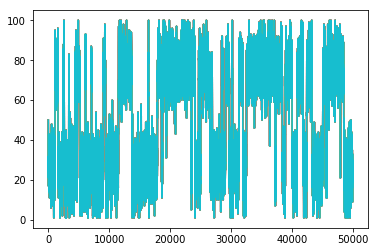

In [48]:
for i in range(len(simulation_data)):
    plt.plot(simulation_data[num_of_coors-1].data)

In [49]:
test_data = np.zeros((num_of_sims_pc,num_of_coors,np.shape(simulation_data[0].data)[0]))
for j in range(num_of_sims_pc):
    for i in range(num_of_coors):
        test_data[j][i][:]=simulation_data[i].data

In [50]:
result=np.zeros((num_of_sims_pc,np.shape(simulation_data[0].data)[0]))
for i in range(num_of_sims_pc):
    for j in range(np.shape(simulation_data[0].data)[0]):
        if simulation_data[i*num_of_coors+(num_of_coors-1)].data[j] >= 55:
            result[i][j] = 1
        if simulation_data[i*num_of_coors+(num_of_coors-1)].data[j] <= 45:
            result[i][j] = -1

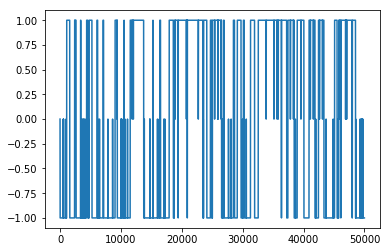

In [51]:
plt.plot(result.T)

# Test train splitting

In [121]:
#Neural Network specific modules
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = test_data.T #Remember it has to be (n_samples,n_features)

y = result.T #It can be either (n_samples) or (n_samples,n_outputs) I did the first option

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

In [122]:
#print(y_train.shape)
X_train = np.squeeze(X_train,axis=2)
X_test = np.squeeze(X_test,axis=2)
y_train = np.squeeze(y_train,axis=1)
y_test = np.squeeze(y_test,axis=1)

# Neural network

In [69]:
#Training the Neural Network
mlp = MLPClassifier(max_iter=800, shuffle=True)

neural_network = mlp.fit(X_train,y_train) 

#Do the predictions for the X_test

y_predicted = neural_network.predict(X_test)

#The results are the difference between the y_test set and the final prediction

results = y_test == y_predicted

In [70]:
results.mean()

0.98885

# Logistic regression

In [123]:
## Try logistic regression
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
results_lr = y_test == y_pred

In [124]:
results_lr.mean()

0.9999

In [125]:
print(clf.coef_)

[[-1.53009080e-02 -4.89510506e-03  1.36332491e-02  3.58871230e-04
  -1.77609472e-04 -6.13658555e-03  7.26241583e-03  8.32001773e-04
  -1.79429754e-03 -4.40626057e+00]
 [ 3.13680004e-03  5.44065384e-03 -2.23892873e-04  5.79219909e-03
   9.28094577e-03 -1.12158188e-03  9.30655342e-03 -3.63547851e-03
   1.94697704e-03  7.43311699e-01]
 [ 1.21641080e-02 -5.45548781e-04 -1.34093562e-02 -6.15107032e-03
  -9.10333630e-03  7.25816743e-03 -1.65689692e-02  2.80347674e-03
  -1.52679497e-04  3.66294887e+00]]


# Questions to investigate

1. How do results change as we vary the amount of the data used?
2. How do results change if instead of one long simulation, we run many short simulations?
3. Can neural networks (or any other method) unbias from a linear transformation of our coordinates? 

## Linear transformation

In [133]:
L = np.random.rand(num_of_coors,num_of_coors)
L_data = np.squeeze(test_data,axis=0)
L_data = np.matmul(L,L_data)

inv_L = np.linalg.inv(L)
print(inv_L[-1][:])

[-0.75550131 -1.08765054  0.19718112  0.86156946 -0.12700536 -0.79986272
 -0.509793    0.81449434  1.75491631  0.32644416]


In [134]:
X = L_data.T #Remember it has to be (n_samples,n_features)
y = result.T #It can be either (n_samples) or (n_samples,n_outputs) I did the first option
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)
y_train = np.squeeze(y_train,axis=1)
y_test = np.squeeze(y_test,axis=1)

In [135]:
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(45000, 10)
(45000,)
(5000, 10)
(5000,)


## Testing with transformed data

In [136]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
results_lr = y_test == y_pred

In [137]:
results_lr.mean()

0.9838

I find that using linear transformed data (jumbling up my features), the model can still identify the important RC with high accuracy.

# Preparation of data for LSTM

# LSTM model

In [ ]:
# lstm
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Flatten
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[0],X_train.shape[2])))
model.add(Dense(1))
#model.add(Flatten())
model.compile(loss='mae', optimizer='adam')
# fit network

In [ ]:
print(np.shape(X_train))
print(model.output_shape)
print(model.input_shape)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
#plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
#plt.legend()
#plt.show()
yhat = model.predict(X_test)

In [ ]:
history

In [ ]:
#plt.plot(yhat)
plt.plot(y_train)
